В этом проекте попробуем узнать как количество активных клиентов влияет на нагрузку отдела Support и предсказать количество обращений при увеличении числа активных клиентов до 30 000 в месяц.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from pandas import Series
pd.options.mode.chained_assignment = None
import plotly.express as px
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import pprint
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
intercom2020 = pd.read_csv('/content/inbox-data-export.csv') #выгрузка по диалогам за 2020
transactions = pd.read_csv('/content/transactions.csv') #активные клиенты и их транзакции с момента запуска карточной программы

In [3]:
intercom2020['Created at'] = pd.to_datetime(intercom2020['Created at'])
transactions['created_at'] = pd.to_datetime(transactions['created_at'])

In [4]:
intercom_from_august = intercom2020[(intercom2020['Created at'] > 
                                     '2020-08-01T00:50:03.286012') & 
                                    (intercom2020['Created at'] < 
                                     '2021-01-01T00:50:03.286012')]
transactions_2020 = transactions[transactions['created_at'] < '2021-01-01']

## Найдем процент обращений от активных клиентов среди всех обращений по месяцам.

In [5]:
intercom_from_august['If_user'] = intercom_from_august['User ID'].str.isdigit()
intercom_users = intercom_from_august[intercom_from_august['If_user'] == True]
transactions_2020 = transactions_2020.reset_index(drop=True)
transactions_2020.columns = ['User ID', 'created_at', 'reference_type']
intercom_users['User ID'] = intercom_users['User ID'].astype(int)
transactions_2020['User ID'] = transactions_2020['User ID'].astype(int)

In [6]:
#найдем уникальные User ID активных клиентов и клиентов обратившихся в поддержку за период
def create_sets_of_users(active_by_period, intercom_by_period, column_name, unique_periods):
  d_interc = {} #клиенты обратившиеся в поддержку (только юзеры)
  d_trans = {} #активные клиенты
  for i in range(min(unique_periods), max(unique_periods) + 1):
    temp = intercom_by_period.loc[i,].reset_index()
    temp2 = active_by_period.loc[i,].reset_index()
    d_interc[i] = set(temp['User ID'])
    d_trans[i] = set(temp2['User ID'])
  return d_interc, d_trans

In [7]:
#найдем % активных клиентов из всех юзеров обратившихся в саппорт
def calculate_percent_of_active(d_interc, d_trans, unique_periods):
  percent_of_active_by_period = {} 
  percent_of_ctive_contacted_support = {}
  for i in range(min(unique_periods), max(unique_periods) + 1):
    intersection = d_interc[i].intersection(d_trans[i]) #активные клинты обратившиеся в саппорт
    percent_of_active_by_period[i] = round(len(intersection)/len(d_interc[i]) * 100) #% активных из всех обратившихся
    percent_of_ctive_contacted_support[i] = round(len(intersection)/len(d_trans[i]) * 100) #% активных, обратившихся в саппорт из всех активных
  return percent_of_active_by_period, percent_of_ctive_contacted_support

In [8]:
def plot_bar(percent_of_active_by_period):
  plt.figure(figsize=(10,6))
  plt.bar(range(len(percent_of_active_by_period)), list(percent_of_active_by_period.values()), align='center')
  plt.xticks(range(len(percent_of_active_by_period)), list(percent_of_active_by_period.keys()))
  plt.title('% активных клиентов, обратившихся в поддержку')
  plt.xlabel('Интервал')
  plt.ylabel('%')

  plt.show()

In [9]:
#тут количество активных клиентов обратившихся в саппорт за период
def create_dict_for_lin_r(d_interc, d_trans, unique_periods):
  d_intersec_period = {} 
  for i in range(min(unique_periods), max(unique_periods) + 1):
    intersection = d_interc[i].intersection(d_trans[i])
    d_intersec_period[len(d_trans[i])] = len(intersection)
  return d_intersec_period

In [10]:
# посмотрим модель линейной регрессии
def perform_linear_regression(X, Y, xlabel, ylabel):
  X = X.reshape(-1, 1)
  Y = Y.reshape(-1, 1)
  #2: Split on train and test
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 124)
  #3. Create empty model
  linear_regressor = LinearRegression()  # create an instance of the class
  #4. Fit the model
  linear_regressor.fit(X_train, Y_train)  # perform linear regression
  #5. Predict Test outcomes and calculate error
  Y_pred = linear_regressor.predict(X_test)  # make predictions
  print('Средняя квадратичная ошибка:', mse(Y_test, Y_pred))
  print('Средняя абсолютная ошибка:', mae(Y_test, Y_pred))

  plt.figure(figsize=(10,6))
  plt.scatter(X_test,Y_test)

  plt.plot(X_test,Y_pred, c='red')
  

  plt.title('График линейной регрессии')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  
  plt.show()

  return linear_regressor

In [11]:
# функция, которая включает в себя все предыдущие и вызывает результат 
def calculate_linear_regression(granularity):
  column_name = 'Created_at_' + granularity
  if granularity == 'month':
    transactions_2020[column_name] = transactions_2020['created_at'].dt.month
    intercom_users[column_name] = intercom_users['Created at'].dt.month
  elif granularity == 'week':
    transactions_2020[column_name] = transactions_2020['created_at'].dt.week
    intercom_users[column_name] = intercom_users['Created at'].dt.week
  elif granularity == 'day':
    transactions_2020[column_name] = transactions_2020['created_at'].dt.dayofyear
    intercom_users[column_name] = intercom_users['Created at'].dt.dayofyear
  elif granularity == 'fifth':
    transactions_2020['day_num'] = transactions_2020['created_at'].dt.dayofyear
    intercom_users['day_num'] = intercom_users['Created at'].dt.dayofyear
    intercom_by_day = intercom_users.pivot_table(index=['day_num', 'User ID'], values='Created at', aggfunc='count').reset_index()
    step = np.array_split(np.array(intercom_by_day['day_num'].unique()), round((366-229) / 5))
    step = [list(i) for i in step]
    d = {}
    for i in range(len(step)):
      for j in step[i]:
        d[j] = i
    transactions_2020[column_name] = [d[i] for i in transactions_2020['day_num']]
    intercom_users[column_name] = [d[i] for i in intercom_users['day_num']]
  else:
    return 'Unknown Granularity'

  active_by_period = transactions_2020.pivot_table(index=[column_name, 'User ID'], values='created_at', aggfunc='count')
  intercom_by_period = intercom_users.pivot_table(index=[column_name, 'User ID'], values='Conversation ID', aggfunc='count')
  unique_periods = list(active_by_period.reset_index()[column_name].unique())

  d_interc, d_trans = create_sets_of_users(active_by_period, intercom_by_period, column_name, unique_periods)

  percent_of_active_by_period, percent_of_ctive_contacted_support = calculate_percent_of_active(d_interc, d_trans, unique_periods)
  
  plot_bar(percent_of_active_by_period)
  d_intersec_period = create_dict_for_lin_r(d_interc, d_trans, unique_periods)
  print('Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале')
  pp = pprint.PrettyPrinter(indent=4)
  pp.pprint(percent_of_active_by_period)
  print('Средний процент активных клиентов, обратившихся в саппорт из общего количества активных клиентов', round(np.array(list(percent_of_ctive_contacted_support.values())).mean(), 2))
  print('Средний процент активных клиентов из всех обратившихся юзеров', round(np.array(list(percent_of_active_by_period.values())).mean(), 2))
  X = np.array(list(d_intersec_period.keys()))
  Y = np.array(list(d_intersec_period.values()))
  return perform_linear_regression(X,Y, 'Количество активных клиентов (ак)', 'Количество ак, обратившихся в саппорт ')



## Прогноз на выборке с интервалом в 1 месяц

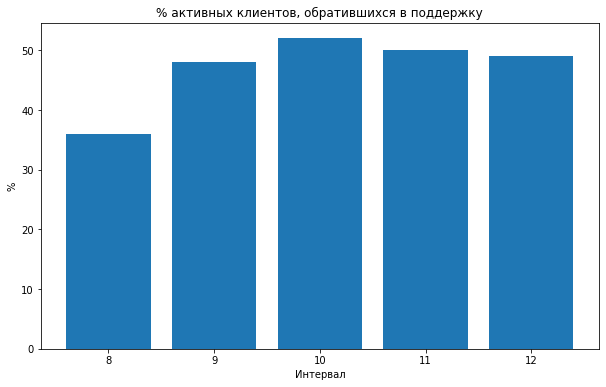

Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале
{8: 36, 9: 48, 10: 52, 11: 50, 12: 49}
Средний процент активных клиентов, обратившихся в саппорт из общего количества активных клиентов 24.6
Средний процент активных клиентов из всех обратившихся юзеров 47.0
Средняя квадратичная ошибка: 1296.1712876839001
Средняя абсолютная ошибка: 36.00237891700908


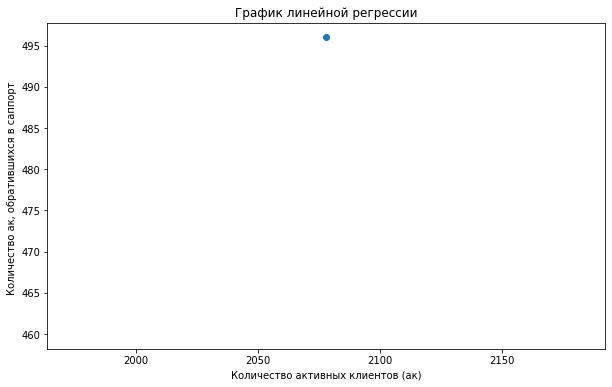

Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 30 000 в месяц: 8584


In [12]:
lr_month = calculate_linear_regression('month')
print('Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 30 000 в месяц:', round(lr_month.predict(np.array([30000]).reshape(-1, 1))[0][0])) 


In [13]:
print('Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период:', round(100 / 47 * lr_month.predict(np.array([30000]).reshape(-1, 1))[0][0]))

Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период: 18264


## Прогноз на выборке с недельным интервалом

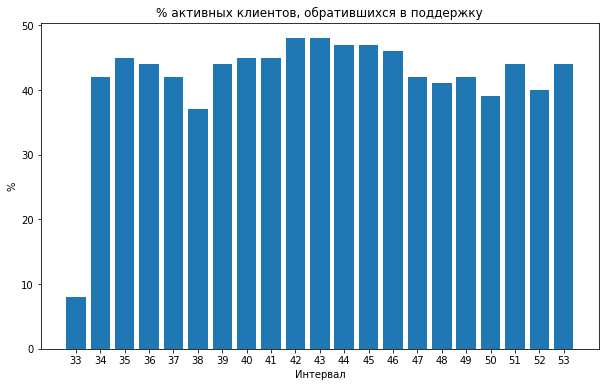

Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале
{   33: 8,
    34: 42,
    35: 45,
    36: 44,
    37: 42,
    38: 37,
    39: 44,
    40: 45,
    41: 45,
    42: 48,
    43: 48,
    44: 47,
    45: 47,
    46: 46,
    47: 42,
    48: 41,
    49: 42,
    50: 39,
    51: 44,
    52: 40,
    53: 44}
Средний процент активных клиентов, обратившихся в саппорт из общего количества активных клиентов 12.9
Средний процент активных клиентов из всех обратившихся юзеров 41.9
Средняя квадратичная ошибка: 184.55370683890678
Средняя абсолютная ошибка: 13.327506492426286


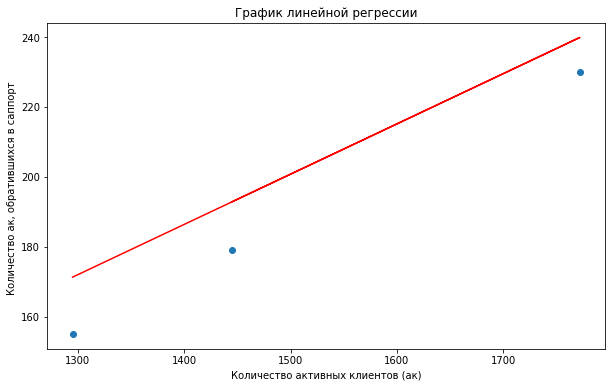

Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 7 500 в неделю: 1064


In [14]:
lr_week = calculate_linear_regression('week')
print('Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 7 500 в неделю:',
      round(lr_week.predict(np.array([7500]).reshape(-1, 1))[0][0]))

In [15]:
print('Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период:', round(100 / 41.9 * lr_week.predict(np.array([7500]).reshape(-1, 1))[0][0])) 

Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период: 2539


## Проноз на выборке с интервалом в 5 дней

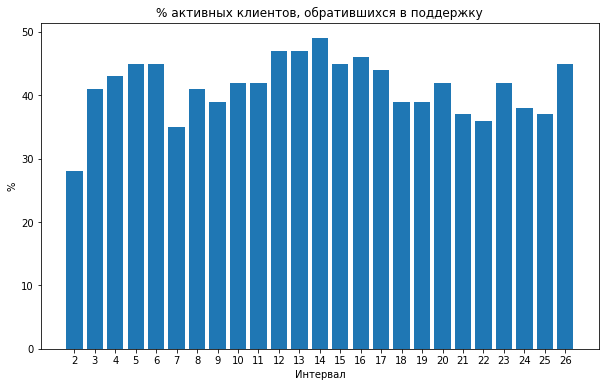

Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале
{   2: 28,
    3: 41,
    4: 43,
    5: 45,
    6: 45,
    7: 35,
    8: 41,
    9: 39,
    10: 42,
    11: 42,
    12: 47,
    13: 47,
    14: 49,
    15: 45,
    16: 46,
    17: 44,
    18: 39,
    19: 39,
    20: 42,
    21: 37,
    22: 36,
    23: 42,
    24: 38,
    25: 37,
    26: 45}
Средний процент активных клиентов, обратившихся в саппорт из общего количества активных клиентов 12.04
Средний процент активных клиентов из всех обратившихся юзеров 41.36
Средняя квадратичная ошибка: 11.36663163950229
Средняя абсолютная ошибка: 2.9352187620525


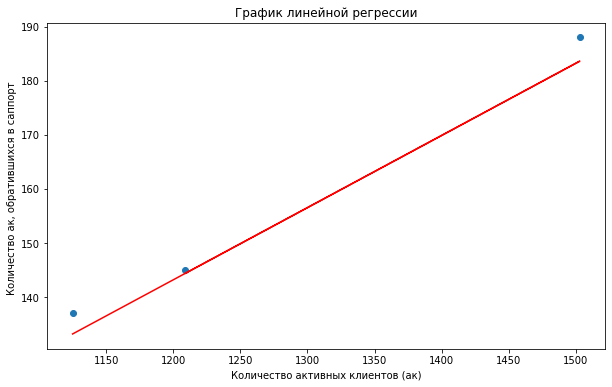

Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 5 000 за 5 дней: 650


In [16]:
lr_five = calculate_linear_regression('fifth')
print('Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 5 000 за 5 дней:', round(lr_five.predict(np.array([5000]).reshape(-1, 1))[0][0])) 

In [17]:
print('Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период:', round(100 / 41.36 * lr_five.predict(np.array([5000]).reshape(-1, 1))[0][0])) 

Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период: 1572


# Подготовим данные для построения модели линейной регрессии для предсказания количества входящих обращений от пользователей и лидов.


In [18]:
intercom_aug_dec = intercom_from_august
intercom_aug_dec['Date_only'] = intercom_from_august['Created at'].dt.date
intercom_aug_dec['Month'] = intercom_aug_dec['Created at'].dt.month
intercom_aug_dec # выгрузка из интеркома с августа по декабрь

,Conversation ID,Conversation URL,Title,Conversation status,Conversation tags,Created at,Last updated at,Time Zone,Inbound/Outbound,Reopened,Closed,Conversation rating,Conversation rating remark,Email,Location,Name,Type,Participated (name),User ID,Assigned to (name),Closed by (name),Teammates participated,Time to first reply (seconds),Time to last close (seconds),Teammate replies,Channel,Source,If_user,Date_only,Month
0,19131500062955,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-11-01 07:19:36,2020-11-01 15:13:55,London,Inbound,0,1,NaN,NaN,kconnect@mailfence.com,United Kingdom,NaN,User,NaN,826481,Valerie,Valerie,Valerie,7445.0,20279.0,1,Desktop,Article,True,2020-11-01,11
1,19131500063032,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-11-01 11:02:28,2020-11-01 12:11:21,London,Outbound,0,1,NaN,NaN,marco.luis@protonmail.com,"Windhoek, Namibia",Marco Artur Soares Marques Luis,User,Marco Artur Soares Marques Luis,561912,Renata,Renata,Renata,68.0,4133.0,1,Desktop,NaN,True,2020-11-01,11
2,19131500062837,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-10-31 18:32:05,2020-11-01 10:30:27,London,Outbound,0,1,NaN,NaN,blacktear37@yahoo.com,"Athens, Greece",Gabriela Alina Chira,User,Gabriela Alina Chira,532836,First level support,Alina,NaN,NaN,701.0,0,Desktop,NaN,True,2020-10-31,10
3,19131500062826,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-10-31 17:58:39,2020-11-01 09:09:53,London,Inbound,0,1,NaN,NaN,NaN,"Istanbul, Turkey",NaN,Lead,NaN,f7ce5635-00c2-4f7b-8d31-11d0100b0c03,Alina,Alina,Alina,593.0,593.0,1,Desktop,NaN,False,2020-10-31,10
4,19131500062661,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,**EU_card**,2020-10-31 10:47:26,2020-10-31 11:07:46,London,Inbound,0,1,NaN,NaN,NaN,"Ludhiana, India",NaN,Lead,NaN,aed96b41-cbf7-42a7-9ee9-95929d225a0f,Daniel,Daniel,Daniel,688.0,1220.0,1,Desktop,NaN,False,2020-10-31,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37957,19131500080798,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Snoozed,**EU_card**,2020-12-07 14:31:14,2021-01-17 16:26:38,London,Inbound,1,2,NaN,NaN,cc.oscar.carlson@gmail.com,"Stockholm, Sweden",Oscar Carl Christer Carlson,User,Oscar Carl Christer Carlson,823429,Daniel,Daniel,Daniel,168.0,1037.0,5,Desktop,NaN,True,2020-12-07,12
37959,19131500087271,https://app.intercom.com/a/apps/h202fg1c/inbox...,WG: Cryptopay-Konto geschlossen,Open,NaN,2020-12-19 21:52:10,2021-01-18 06:00:16,London,Inbound,1,1,NaN,NaN,souveraen.peter@aon.at,"Greith, Austria",Peter Heiss,User,Peter Heiss,120151,Konstantin,Daniel,"Daniel,Konstantin",3578.0,15477.0,6,Email,NaN,True,2020-12-19,12
37960,19131500066811,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,"**EU_card**, i-want-to-manage-btc-addresses-i-...",2020-11-10 15:25:19,2020-12-18 10:25:01,London,Inbound,0,7,NaN,NaN,pandabulltrader@gmail.com,United Kingdom,Allan James Irving,User,Allan James Irving,795598,Alex,Alex,"Renata,Luda,Alex",27.0,1378782.0,12,Android App,NaN,True,2020-11-10,11
37961,19131500086023,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,*bank_transfers*,2020-12-17 16:04:02,2020-12-18 10:30:48,London,Inbound,0,1,NaN,NaN,pandabulltrader@gmail.com,United Kingdom,Allan James Irving,User,Allan James Irving,795598,Alyona,NaN,Alyona,4439.0,NaN,7,Android App,NaN,True,2020-12-17,12


In [19]:
intercom_aug_dec['Minutes to first reply'] = intercom_aug_dec['Time to first reply (seconds)'] / 60

In [20]:
# выгрузим таблицу с активными клиентами с августа по декабрь
transactions_aug_dec = transactions_2020[transactions_2020['Created_at_month'] > 7]
transactions_aug_dec

,User ID,created_at,reference_type,Created_at_month,Created_at_week,day_num,Created_at_fifth
0,825332,2020-12-31 23:58:01.447844,CoinDeposit,12,53,366,26
1,775239,2020-12-31 23:50:02.474147,CoinDeposit,12,53,366,26
2,460300,2020-12-31 23:48:45.844693,CoinDeposit,12,53,366,26
3,709924,2020-12-31 23:48:18.293100,CoinWithdrawal,12,53,366,26
4,825332,2020-12-31 23:48:01.497127,CoinDeposit,12,53,366,26
...,...,...,...,...,...,...,...
115128,799363,2020-08-16 01:09:06.341664,CoinWithdrawal,8,33,229,2
115129,799363,2020-08-16 01:08:00.378587,CardDeposit,8,33,229,2
115130,342927,2020-08-16 01:07:51.063378,CoinDeposit,8,33,229,2
115131,652216,2020-08-16 00:50:03.764868,CoinDeposit,8,33,229,2


In [21]:
transactions_aug_dec['Date_only'] = transactions_aug_dec['created_at'].dt.date
transactions_aug_dec

,User ID,created_at,reference_type,Created_at_month,Created_at_week,day_num,Created_at_fifth,Date_only
0,825332,2020-12-31 23:58:01.447844,CoinDeposit,12,53,366,26,2020-12-31
1,775239,2020-12-31 23:50:02.474147,CoinDeposit,12,53,366,26,2020-12-31
2,460300,2020-12-31 23:48:45.844693,CoinDeposit,12,53,366,26,2020-12-31
3,709924,2020-12-31 23:48:18.293100,CoinWithdrawal,12,53,366,26,2020-12-31
4,825332,2020-12-31 23:48:01.497127,CoinDeposit,12,53,366,26,2020-12-31
...,...,...,...,...,...,...,...,...
115128,799363,2020-08-16 01:09:06.341664,CoinWithdrawal,8,33,229,2,2020-08-16
115129,799363,2020-08-16 01:08:00.378587,CardDeposit,8,33,229,2,2020-08-16
115130,342927,2020-08-16 01:07:51.063378,CoinDeposit,8,33,229,2,2020-08-16
115131,652216,2020-08-16 00:50:03.764868,CoinDeposit,8,33,229,2,2020-08-16


In [22]:
#создадим таблицу с количеством активных клиентов по дням
pivot_active = transactions_aug_dec.pivot_table(index='Date_only', values='User ID', aggfunc='nunique')
pivot_active = pivot_active.reset_index()
pivot_active

,Date_only,User ID
0,2020-08-16,247
1,2020-08-17,340
2,2020-08-18,320
3,2020-08-19,376
4,2020-08-20,339
...,...,...
133,2020-12-27,524
134,2020-12-28,480
135,2020-12-29,542
136,2020-12-30,508


In [23]:
pivot_active['Date_only'] = pd.to_datetime(pivot_active['Date_only'])

In [24]:
#создадим таблицу с количеством активных клиентов по месяцам
pivot_active_month = transactions_aug_dec.pivot_table(index='Created_at_month', values='User ID', aggfunc='nunique')
pivot_active_month = pivot_active_month.reset_index()
pivot_active_month

,Created_at_month,User ID
0,8,2078
1,9,2852
2,10,2986
3,11,3792
4,12,4219


In [25]:
pivot_active = transactions_aug_dec.pivot_table(index='Created_at_month', values='User ID', aggfunc='nunique')
pivot_active = pivot_active.reset_index()
pivot_active

,Created_at_month,User ID
0,8,2078
1,9,2852
2,10,2986
3,11,3792
4,12,4219


In [26]:
pivot_active.columns = ['Month', 'Num_of_active']

In [27]:
pivot_by_month = intercom_aug_dec.pivot_table(index='Month', \
                                         aggfunc={'Minutes to first reply': ['mean', 'median'], \
                                                  'Conversation rating' : ['mean', 'median'],
                                                  'Conversation ID' : 'count'})
pivot_by_month


Conversation ID Conversation rating  ... Minutes to first reply           
                count                mean  ...                   mean     median
Month                                      ...                                  
8                2736            4.387534  ...              49.192053   7.150000
9                2711            4.438889  ...              18.219860   6.416667
10               2755            4.419948  ...              17.973871   6.400000
11               3653            4.436464  ...              61.948538   9.416667
12               4668            4.387097  ...             116.478779  10.300000

[5 rows x 5 columns]

In [28]:
pivot_by_month.columns = pivot_by_month.columns.droplevel()

In [29]:
pivot_by_month.columns= ['Num_of_chats', 'Rating_mean', 'Rating_median', 'FRT_mean', 'FRT_median']
pivot_by_month = pivot_by_month.reset_index()
pivot_by_month

,Month,Num_of_chats,Rating_mean,Rating_median,FRT_mean,FRT_median
0,8,2736,4.387534,5.0,49.192053,7.150000
1,9,2711,4.438889,5.0,18.219860,6.416667
2,10,2755,4.419948,5.0,17.973871,6.400000
3,11,3653,4.436464,5.0,61.948538,9.416667
4,12,4668,4.387097,5.0,116.478779,10.300000


In [30]:
final_by_month = pivot_by_month.merge(pivot_active, how='inner', on='Month')
final_by_month

,Month,Num_of_chats,Rating_mean,Rating_median,FRT_mean,FRT_median,Num_of_active
0,8,2736,4.387534,5.0,49.192053,7.150000,2078
1,9,2711,4.438889,5.0,18.219860,6.416667,2852
2,10,2755,4.419948,5.0,17.973871,6.400000,2986
3,11,3653,4.436464,5.0,61.948538,9.416667,3792
4,12,4668,4.387097,5.0,116.478779,10.300000,4219


In [31]:
pivot_active_week = transactions_aug_dec.pivot_table(index='Created_at_week', values='User ID', aggfunc='nunique')
pivot_active_week = pivot_active_week.reset_index()
pivot_active_week

,Created_at_week,User ID
0,33,247
1,34,1309
2,35,1224
3,36,1295
4,37,1176
5,38,1143
6,39,1203
7,40,1238
8,41,1171
9,42,1269


In [32]:
pivot_active_week.columns = ['Week', 'Num_of_active']

In [33]:
intercom_aug_dec['Week'] = intercom_aug_dec['Created at'].dt.week

In [34]:
pivot_by_week = intercom_aug_dec.pivot_table(index='Week', \
                                         aggfunc={'Minutes to first reply': ['mean', 'median'], \
                                                  'Conversation rating' : ['mean', 'median'],
                                                  'Conversation ID' : 'count'})
pivot_by_week

Conversation ID Conversation rating  ... Minutes to first reply           
               count                mean  ...                   mean     median
Week                                      ...                                  
31               122            4.454545  ...              27.542982   7.650000
32               615            4.126761  ...              21.254415   7.133333
33               552            4.530303  ...              15.460471   6.383333
34               763            4.383929  ...             121.347218   8.633333
35               581            4.439560  ...              19.845648   6.633333
36               634            4.523256  ...              17.270250   7.216667
37               618            4.464286  ...              24.018723   6.816667
38               551            4.394737  ...              16.574687   6.450000
39               711            4.445652  ...              16.533514   5.466667
40               603            4.333333  ...              14.290816   5.816667
41               598            4.447368  ...              19.371637   6.950000
42               601            4.482759  ...              14.452120   5.916667
43               661            4.387500  ...              16.474751   5.825000
44               654            4.446602  ...              24.141187   7.116667
45               668            4.463636  ...             130.550246   7.066667
46               630            4.520000  ...              13.565999   6.758333
47               926            4.416000  ...              54.716819  11.433333
48              1159            4.390533  ...              62.436727  12.550000
49              1062            4.321678  ...              98.493251  12.150000
50               980            4.240602  ...             149.308116   9.616667
51              1107            4.471338  ...             109.385075   9.366667
52              1049            4.415493  ...              84.039009  10.550000
53               678            4.471698  ...             132.409599  10.825000

[23 rows x 5 columns]

In [35]:
pivot_by_week.columns = pivot_by_week.columns.droplevel()

In [36]:
pivot_by_week.columns= ['Num_of_chats', 'Rating_mean', 'Rating_median', 'FRT_mean', 'FRT_median']
pivot_by_week = pivot_by_week.reset_index()
pivot_by_week

,Week,Num_of_chats,Rating_mean,Rating_median,FRT_mean,FRT_median
0,31,122,4.454545,5.0,27.542982,7.650000
1,32,615,4.126761,4.0,21.254415,7.133333
2,33,552,4.530303,5.0,15.460471,6.383333
3,34,763,4.383929,5.0,121.347218,8.633333
4,35,581,4.439560,5.0,19.845648,6.633333
5,36,634,4.523256,5.0,17.270250,7.216667
6,37,618,4.464286,5.0,24.018723,6.816667
7,38,551,4.394737,5.0,16.574687,6.450000
8,39,711,4.445652,5.0,16.533514,5.466667
9,40,603,4.333333,5.0,14.290816,5.816667


In [37]:
final_by_week = pivot_by_week.merge(pivot_active_week, how='inner', on='Week')
final_by_week

,Week,Num_of_chats,Rating_mean,Rating_median,FRT_mean,FRT_median,Num_of_active
0,33,552,4.530303,5.0,15.460471,6.383333,247
1,34,763,4.383929,5.0,121.347218,8.633333,1309
2,35,581,4.439560,5.0,19.845648,6.633333,1224
3,36,634,4.523256,5.0,17.270250,7.216667,1295
4,37,618,4.464286,5.0,24.018723,6.816667,1176
5,38,551,4.394737,5.0,16.574687,6.450000,1143
6,39,711,4.445652,5.0,16.533514,5.466667,1203
7,40,603,4.333333,5.0,14.290816,5.816667,1238
8,41,598,4.447368,5.0,19.371637,6.950000,1171
9,42,601,4.482759,5.0,14.452120,5.916667,1269


## Модель линейной регрессии для предсказания количества диалогов в зависимости от количества активных клиентов по месяцам

Средняя квадратичная ошибка: 1447580.877658687
Средняя абсолютная ошибка: 1203.1545526900054


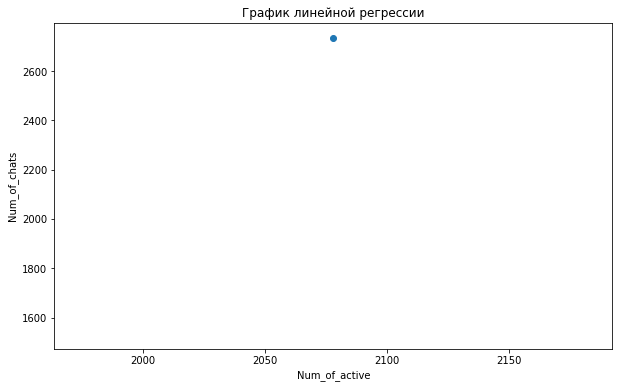

Ожидаемое количество входящих обращений при количестве активных клиентов 30000 в месяц:  [[40139.]]


In [40]:
lr_active_chats = perform_linear_regression(final_by_month['Num_of_active'].values, final_by_month['Num_of_chats'].values, 'Num_of_active', 'Num_of_chats')
print('Ожидаемое количество входящих обращений при количестве активных клиентов 30000 в месяц: ', np.round(lr_active_chats.predict(np.array([30000]).reshape(1, -1))))

## Модель линейной регрессии для предсказания количества диалогов в зависимости от количества активных клиентов по неделям

Средняя квадратичная ошибка: 15981.000940129592
Средняя абсолютная ошибка: 123.23541989534283


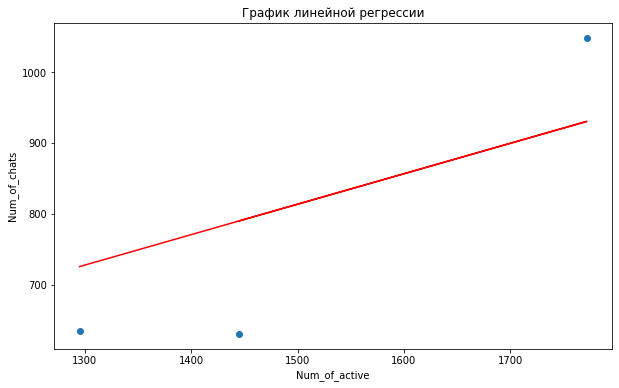

Ожидаемое количество входящих обращений при количестве активных клиентов 7500 в неделю:  [[3394.]]


In [39]:
lr_active_chats = perform_linear_regression(final_by_week['Num_of_active'].values, final_by_week['Num_of_chats'].values, 'Num_of_active', 'Num_of_chats')
print('Ожидаемое количество входящих обращений при количестве активных клиентов 7500 в неделю: ', np.round(lr_active_chats.predict(np.array([7500]).reshape(1, -1))))